This notebook contains the code used in the BigComp 2022 paper: <br>
<b>Heeryon Cho, Woo-Kyu Kang, Younsoo Park, Sungeu Chae, and Seong-joon Kim, "Multi-label Facial Emotion Recognition Using Korean Drama Movie Clips," BigComp 2022.</b>
### Autoencoder /  Classify 22 Emotions

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rn
import os

In [2]:
import warnings
import logging
logging.getLogger('tensorflow').disabled = True
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
# Record cell run time.
!pip install ipython-autotime

%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 21.6 MB/s 
time: 525 µs (started: 2022-11-20 16:40:07 +00:00)


In [4]:
# Set seed for reproducibility.

set_seed = 46
np.random.seed(set_seed)
rn.seed(set_seed)
tf.random.set_seed(set_seed)

time: 1.24 ms (started: 2022-11-20 16:40:07 +00:00)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 17 s (started: 2022-11-20 16:40:12 +00:00)


### Load pretrained autoencoder.

In [6]:
# Create autoencoder model (skeleton) for loading pretrained weights.

def create_autoencoder():
    # Define the model
    model = Sequential()

    #1st convolution layer
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(64,64,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

    #2nd convolution layer
    model.add(Conv2D(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

    #3rd convolution layer
    model.add(Conv2D(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))    

    #1st deconvolution layer
    model.add(Conv2DTranspose(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))
    
    #2nd deconvolution layer
    model.add(Conv2DTranspose(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))

    #3rd deconvolution layer
    model.add(Conv2DTranspose(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))    
    
    model.add(Conv2D(3,(3, 3), padding='same'))
    model.add(Activation('sigmoid'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy')
    model.summary()
    
    return model

time: 6.16 ms (started: 2022-11-20 16:40:29 +00:00)


In [7]:
# Load pretrained autoencoder weights.

checkpoint_path = "/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/model/autoencoder.ckpt"
autoencoder = create_autoencoder()
autoencoder.load_weights(checkpoint_path)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                    

time: 4.03 s (started: 2022-11-20 16:40:38 +00:00)


### The below code is for creating training data tfrecord and idx file from images. (We do not use the below code in this jupyter notebook since we import tfrecords directly.)

```python
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.

from itertools import islice
from subprocess import call

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

#def _float_feature(value):
#    """Returns a float_list from a float / double."""
#    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    if type(value) != list:
        value = [value]
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

# Create a dictionary with relevant features.

def image_example(image_string, label):
    image_shape = tf.io.decode_jpeg(image_string).shape

    feature = {
        'height': _int64_feature(image_shape[0]),
        'width': _int64_feature(image_shape[1]),
        'depth': _int64_feature(image_shape[2]),
        'label': _int64_feature(label),
        'image_raw': _bytes_feature(image_string),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def gen_tfrecord_idx(tfrecord_file, dict_label, tfrecord_idx):
    with tf.io.TFRecordWriter(tfrecord_file) as writer:
        for filename, label in dict_label.items():
            fname = "./image/" + filename
            image_string = open(fname, 'rb').read()
            tf_example = image_example(image_string, label)
            writer.write(tf_example.SerializeToString())

    tfrecord2idx_script = "tfrecord2idx"

    if not os.path.isfile(tfrecord_idx):
        call([tfrecord2idx_script, tfrecord_file, tfrecord_idx])


#--------------------------------------------
# VALID DATA: Load labels, check headers, check data shape.

df_label_valid = pd.read_csv('label/label_22_emo_valid.csv')
print("valid columns:", df_label_valid.columns)
print("valid shape:", df_label_valid.shape)

# Place labels into a dictionary.

dict_label_valid = {}
for idx, row in df_label_valid.iterrows():
    dict_label_valid[row['img_id']] = list(row['moved':'disgusted'].values)
len(dict_label_valid)

#--------------------------------------------
# Create VALID tfrecord & idx files from jpg images.

tfrecord_file_valid = './tfrecords/22_emo_valid.tfrecords'
tfrecord_idx_valid = './tfrecords/22_emo_valid.idx'

gen_tfrecord_idx(tfrecord_file_valid, dict_label_valid, tfrecord_idx_valid)

#--------------------------------------------
# TRAIN DATA: Load labels, check headers, check data shape.

df_label_train = pd.read_csv('label/label_22_emo_train.csv')
print("train columns:", df_label_train.columns)
print("train shape:", df_label_train.shape)

# Place labels into a dictionary.

dict_label_train = {}
for idx, row in df_label_train.iterrows():
    dict_label_train[row['img_id']] = list(row['moved':'disgusted'].values)
len(dict_label_train)

#--------------------------------------------
# Create TRAIN tfrecord & idx files from jpg images.

tfrecord_file_train = './tfrecords/22_emo_train.tfrecords'
tfrecord_idx_train = './tfrecords/22_emo_train.idx'

gen_tfrecord_idx(tfrecord_file_train, dict_label_train, tfrecord_idx_train) 

#--------------------------------------------
# TEST DATA: Load labels, check headers, check data shape.

df_label_test = pd.read_csv('label/label_22_emo_test.csv')
print("test columns:", df_label_test.columns)
print("test shape:", df_label_test.shape)

# Place labels into a dictionary.

dict_label_test = {}
for idx, row in df_label_test.iterrows():
    dict_label_test[row['img_id']] = list(row['moved':'disgusted'].values)
len(dict_label_test)

#-------------------------------------------
# Create TEST tfrecord & idx files from jpg images.

tfrecord_file_test = './tfrecords/22_emo_test.tfrecords'
tfrecord_idx_test = './tfrecords/22_emo_test.idx'

gen_tfrecord_idx(tfrecord_file_test, dict_label_test, tfrecord_idx_test) 

# OUTPUT
# valid columns: Index(['img_id', 'clip_id', 'moved', 'fearful', 'surprised', 'angry',
#       'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled',
#       'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed',
#       'amused', 'affectionate', 'guilty', 'jealous', 'peaceful', 'happy',
#       'disgusted'],
#      dtype='object')
# valid shape: (1980, 22)
# train columns: Index(['img_id', 'clip_id', 'moved', 'fearful', 'surprised', 'angry',
#       'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled',
#       'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed',
#       'amused', 'affectionate', 'guilty', 'jealous', 'peaceful', 'happy',
#       'disgusted'],
#      dtype='object')
# train shape: (15840, 22)
# test columns: Index(['img_id', 'clip_id', 'moved', 'fearful', 'surprised', 'angry',
#       'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled',
#       'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed',
#       'amused', 'affectionate', 'guilty', 'jealous', 'peaceful', 'happy',
#       'disgusted'],
#      dtype='object')
# test shape: (1980, 22)
```  

### Load label data.

In [8]:
# Load labels, check headers, check data shape.

df_label = pd.read_csv('/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/label/label_22_emo.csv')
print(df_label.columns)
print(df_label.shape)

LABELS = list(df_label.columns[2:])
print("LABELS=", LABELS)
print("All classes:", len(LABELS))

label_valid = pd.read_csv('/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/label/label_22_emo_valid.csv')
label_train = pd.read_csv('/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/label/label_22_emo_train.csv')
label_test = pd.read_csv('/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/label/label_22_emo_test.csv')

VALID_DATA_SIZE = label_valid.shape[0]
TRAIN_DATA_SIZE = label_train.shape[0]
TEST_DATA_SIZE = label_test.shape[0]

print("TRAIN_DATA_SIZE:", label_train.shape[0])
print("VALID_DATA_SIZE:", label_valid.shape[0])
print("TEST_DATA_SIZE:", label_test.shape[0])

Index(['img_id', 'clip_id', 'moved', 'fearful', 'surprised', 'angry',
       'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled',
       'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed',
       'amused', 'affectionate', 'guilty', 'jealous', 'peaceful', 'happy',
       'disgusted'],
      dtype='object')
(19800, 24)
LABELS= ['moved', 'fearful', 'surprised', 'angry', 'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled', 'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed', 'amused', 'affectionate', 'guilty', 'jealous', 'peaceful', 'happy', 'disgusted']
All classes: 22
TRAIN_DATA_SIZE: 15840
VALID_DATA_SIZE: 1980
TEST_DATA_SIZE: 1980
time: 1.25 s (started: 2022-11-20 16:41:42 +00:00)


### Calculate class weights.

In [9]:
dict_label_train = {}
for idx, row in label_train.iterrows():
    dict_label_train[row['img_id']] = list(row['moved':'disgusted'].values)
len(dict_label_train)

15840

time: 2.44 s (started: 2022-11-20 16:41:49 +00:00)


In [10]:
y_train_ls = list(dict_label_train.values())
#y_train_ls

time: 1.09 ms (started: 2022-11-20 16:41:51 +00:00)


In [11]:
y_train_ints = [y.index(1) for y in y_train_ls]
#y_train_ints

time: 3.85 ms (started: 2022-11-20 16:41:52 +00:00)


In [12]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight ='balanced',
                                                  classes = np.unique(y_train_ints),
                                                  y = y_train_ints)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 2.88,
 1: 3.2142857142857144,
 2: 0.3314917127071823,
 3: 0.11865524060646011,
 4: 0.9461235216819974,
 5: 3.0,
 6: 5.625,
 7: 0.9809264305177112,
 8: 6.050420168067227,
 9: 12.203389830508474,
 10: 0.46632124352331605,
 11: 0.5286343612334802,
 12: 1.769041769041769,
 13: 32.72727272727273,
 14: 4.444444444444445,
 15: 1.978021978021978,
 16: 2.1114369501466275,
 17: 1.894736842105263,
 18: 5.179856115107913,
 19: 5.853658536585366,
 20: 4.864864864864865,
 21: 7.741935483870968}

time: 132 ms (started: 2022-11-20 16:42:14 +00:00)


In [13]:
class_weights

array([ 2.88      ,  3.21428571,  0.33149171,  0.11865524,  0.94612352,
        3.        ,  5.625     ,  0.98092643,  6.05042017, 12.20338983,
        0.46632124,  0.52863436,  1.76904177, 32.72727273,  4.44444444,
        1.97802198,  2.11143695,  1.89473684,  5.17985612,  5.85365854,
        4.86486486,  7.74193548])

time: 4.83 ms (started: 2022-11-20 16:42:18 +00:00)


In [14]:
n_samples = len(dict_label_train)
n_classes = len(set(y_train_ints))

time: 667 µs (started: 2022-11-20 16:42:19 +00:00)


In [15]:
multiplier = 3
adjusted_cw = class_weights / n_classes * multiplier
adjusted_cw

array([0.39272727, 0.43831169, 0.04520342, 0.01618026, 0.12901684,
       0.40909091, 0.76704545, 0.1337627 , 0.8250573 , 1.66409861,
       0.06358926, 0.0720865 , 0.24123297, 4.46280992, 0.60606061,
       0.26973027, 0.28792322, 0.25837321, 0.70634402, 0.79822616,
       0.66339066, 1.05571848])

time: 4.18 ms (started: 2022-11-20 16:42:20 +00:00)


In [16]:
log_weights = n_samples / (n_classes * np.log(np.bincount(y_train_ints)))
sum_weights = sum(log_weights)
sum_weights
custom_class_weights = log_weights / sum_weights
custom_class_weights

array([0.0446305 , 0.04553616, 0.03207245, 0.02828971, 0.0371423 ,
       0.04496293, 0.05078813, 0.03734564, 0.05156292, 0.0604349 ,
       0.03356322, 0.03414653, 0.04101069, 0.07972248, 0.04843654,
       0.0417872 , 0.04225489, 0.04148459, 0.04993958, 0.05120867,
       0.04931261, 0.05436738])

time: 5.74 ms (started: 2022-11-20 16:42:21 +00:00)


In [17]:
custom_class_weights += adjusted_cw
custom_class_weights

array([0.43735777, 0.48384784, 0.07727586, 0.04446997, 0.16615915,
       0.45405383, 0.81783359, 0.17110834, 0.87662022, 1.72453351,
       0.09715248, 0.10623303, 0.28224366, 4.54253239, 0.65449715,
       0.31151747, 0.33017811, 0.29985779, 0.7562836 , 0.84943483,
       0.71270327, 1.11008586])

time: 3.84 ms (started: 2022-11-20 16:42:22 +00:00)


In [18]:
class_weight_dict = dict(enumerate(custom_class_weights))
class_weight_dict

{0: 0.4373577724452382,
 1: 0.4838478445155733,
 2: 0.07727586270718911,
 3: 0.04446996974668063,
 4: 0.16615914648376193,
 5: 0.4540538346519936,
 6: 0.8178335878697381,
 7: 0.17110833767997752,
 8: 0.8766202151416682,
 9: 1.7245335113550873,
 10: 0.09715247740162058,
 11: 0.10623303005607032,
 12: 0.2822436560295512,
 13: 4.542532394045939,
 14: 0.6544971453809278,
 15: 0.3115174717379668,
 16: 0.3301781117377456,
 17: 0.29985779422458547,
 18: 0.7562835965468601,
 19: 0.8494348339351854,
 20: 0.7127032693872445,
 21: 1.110085855273053}

time: 3.45 ms (started: 2022-11-20 16:42:23 +00:00)


### Define training pipeline.

In [19]:
#https://docs.nvidia.com/deeplearning/dali/user-guide/docs/installation.html
!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-cuda102
!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-tf-plugin-cuda102


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://developer.download.nvidia.com/compute/redist
     |████████████████████████████████| 297.2 MB 15 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://developer.download.nvidia.com/compute/redist
     |████████████████████████████████| 333 kB 1.7 MB/s 
  Created wheel for nvidia-dali-tf-plugin-cuda102: filename=nvidia_dali_tf_plugin_cuda102-1.19.0-cp37-cp37m-linux_x86_64.whl size=120640 sha256=247e1a55fa1dafe1c417da41914c528a8c4be79906efdf26fa95c5aa064feb4c
  Stored in directory: /root/.cache/pip/wheels/97/97/59/545e6b1324a7c6f16ee7daaa70f834c977281ef341eb0d9a76
Successfully built nvidia-dali-tf-plugin-cuda102
time: 48.6 s (started: 2022-11-20 16:42:33 +00:00)


In [20]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import nvidia.dali.tfrecord as tfrec
import nvidia.dali.plugin.tf as dali_tf

class TFRecordPipelineTrain(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineTrain, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([22], tfrec.int64,  22)},
             path = ['/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/tfrecords/22_emo_train.tfrecords'],
             index_path = ['/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/tfrecords/22_emo_train.idx'],
             random_shuffle=True,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 112 ms (started: 2022-11-20 16:43:22 +00:00)


/usr/local/lib/python3.7/dist-packages/nvidia/dali/backend.py:51: Warning: DALI plans to drop the support for CUDA 10.2 in the upcoming releases. Please update your CUDA toolkit.
  "DALI plans to drop the support for CUDA 10.2 in the upcoming releases. "


### Define validation pipeline.

In [21]:
class TFRecordPipelineValid(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineValid, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([22], tfrec.int64,  22)},
             path = ['/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/tfrecords/22_emo_valid.tfrecords'],
             index_path = ['/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/tfrecords/22_emo_valid.idx'],
             random_shuffle=False,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 2.33 ms (started: 2022-11-20 16:43:22 +00:00)


### Train autoencoder model for classifying 22 emotions.

In [23]:
if __name__ == "__main__":
    batch_size = 64
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 22))
    pipe_train = TFRecordPipelineTrain(batch_size=batch_size, 
                                 num_threads=1, 
                                 device='gpu', 
                                 device_id=0)
    
    batch_size_valid = 64
    shapes_valid = ((batch_size_valid, 64, 64, 3),
                    (batch_size_valid, 22))
    pipe_valid = TFRecordPipelineValid(batch_size=batch_size_valid, 
                                 num_threads=1, 
                                 device='gpu', 
                                 device_id=0)        

    with tf.device('/gpu:0'):
        ds_train = dali_tf.DALIDataset(
            pipeline=pipe_train,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)
        
        ds_valid = dali_tf.DALIDataset(
            pipeline=pipe_valid,
            batch_size=batch_size_valid,
            output_shapes=shapes_valid,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)            
      
        initializer = keras.initializers.GlorotUniform(seed=set_seed)
        activation =  keras.activations.softmax
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-5,
            decay_steps=TRAIN_DATA_SIZE // batch_size * 10,
            decay_rate=0.95)
        
        number_of_classes = 22
        
        inputs = keras.Input(shape=(64, 64, 3))
        x = autoencoder(inputs, training=False)   # Fix autoencoder weights.
        flat = keras.layers.Flatten()(x)
        fc1 = keras.layers.Dense(number_of_classes, activation='relu',
                             kernel_initializer=initializer)(flat)
        do1 = keras.layers.Dropout(0.5, seed=set_seed)(fc1)        
        outputs = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer,
                             activation=activation)(do1) 
        clf = keras.Model(inputs, outputs)
        
        clf.summary()

        # To save the model weights, uncomment the below code.        
        #checkpoint_path = "./model/cp_clf_24_emo.ckpt"
        #checkpoint_dir = os.path.dirname(checkpoint_path)
        #cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
        #                                         save_weights_only=True,
        #                                         verbose=1)

        # Apply early stopping.        
        es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                                       restore_best_weights=True)
        
        clf.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy'])
        
        history = clf.fit(ds_train, steps_per_epoch=TRAIN_DATA_SIZE // batch_size, 
                          validation_data=ds_valid.take(VALID_DATA_SIZE // batch_size_valid),
                          epochs=1000,
                          )#callbacks=[es_callback])    

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         48003     
                                                                 
 flatten_1 (Flatten)         (None, 12288)             0         
                                                                 
 dense_2 (Dense)             (None, 22)                270358    
                                                                 
 dropout_1 (Dropout)         (None, 22)                0         
                                                                 
 dense_3 (Dense)             (None, 22)                506       
                                                                 
Total params: 318,867
Trainable params: 318,867
Non-trainab

In [45]:
from keras.models import load_model
clf.save('/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/model/auto_22.h5')

time: 191 ms (started: 2022-11-20 18:03:28 +00:00)


In [24]:
# List all data in history.

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
time: 1.35 ms (started: 2022-11-20 17:59:26 +00:00)


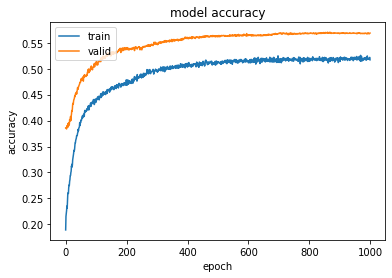

time: 147 ms (started: 2022-11-20 17:59:26 +00:00)


In [25]:
# Summarize history for accuracy.

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

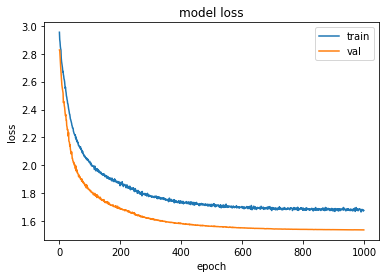

time: 130 ms (started: 2022-11-20 17:59:26 +00:00)


In [26]:
# Summarize history for loss.

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Define test pipeline.

In [27]:
class TFRecordPipelineTest(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineTest, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([22], tfrec.int64,  22)},
             path = ['/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/tfrecords/22_emo_test.tfrecords'],
             index_path = ['/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/tfrecords/22_emo_test.idx'],
             random_shuffle=False,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 1.69 ms (started: 2022-11-20 17:59:27 +00:00)


### Check test data accuracy.

In [28]:
# https://docs.nvidia.com/deeplearning/dali/user-guide/docs/plugins/tensorflow_plugin_api.html

if __name__ == "__main__":
    batch_size = 1
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 22))
    pipe_test = TFRecordPipelineTest(batch_size=batch_size, 
                            num_threads=4, 
                            device='gpu', 
                            device_id=0)

    with tf.device('/gpu:0'):
        ds_test = dali_tf.DALIDataset(
            pipeline=pipe_test,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)
        print(ds_test)
        loss, acc = clf.evaluate(ds_test, steps=TEST_DATA_SIZE)
        print("Test accuracy:", acc)
        predictions = clf.predict(ds_test.take(5))
        print("A test output from the last layer:", predictions[0])
        print("Index of the maximum value:", np.argmax(predictions[0]))
        print("Label:", LABELS[np.argmax(predictions[0])])

<DALIDataset element_spec=(TensorSpec(shape=(1, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1, 22), dtype=tf.int64, name=None))>
1980/1980 [==============================] - 8s 4ms/step - loss: 1.5364 - accuracy: 0.5646
Test accuracy: 0.5646464824676514
5/5 [==============================] - 0s 3ms/step
A test output from the last layer: [1.3220529e-02 4.5219450e-03 5.9230778e-02 7.4350059e-01 1.9794917e-02
 2.8944928e-03 8.9666182e-03 1.8870322e-02 1.6666707e-03 4.7748865e-04
 6.9671765e-02 7.2074295e-03 1.5259890e-02 6.8914535e-04 2.1661681e-03
 8.8420492e-03 8.1977984e-03 3.4175217e-03 5.0171190e-03 4.3323813e-03
 1.0857562e-03 9.6860068e-04]
Index of the maximum value: 3
Label: angry
time: 8.17 s (started: 2022-11-20 17:59:27 +00:00)


In [29]:
predictions

array([[1.32205291e-02, 4.52194503e-03, 5.92307784e-02, 7.43500590e-01,
        1.97949167e-02, 2.89449282e-03, 8.96661822e-03, 1.88703220e-02,
        1.66667067e-03, 4.77488647e-04, 6.96717650e-02, 7.20742950e-03,
        1.52598899e-02, 6.89145352e-04, 2.16616807e-03, 8.84204917e-03,
        8.19779839e-03, 3.41752172e-03, 5.01711899e-03, 4.33238130e-03,
        1.08575623e-03, 9.68600682e-04],
       [1.51067805e-02, 5.68375271e-03, 4.70986404e-02, 7.22757697e-01,
        2.83719525e-02, 5.24815451e-03, 1.03408881e-02, 1.79336090e-02,
        3.66240833e-03, 8.83770816e-04, 5.22792339e-02, 1.97707694e-02,
        1.02955941e-02, 1.36254763e-03, 3.92501475e-03, 1.78842880e-02,
        1.12927826e-02, 9.16753709e-03, 6.77268486e-03, 5.21921273e-03,
        2.46971403e-03, 2.47295108e-03],
       [1.46252122e-02, 8.14713538e-03, 4.09657657e-02, 2.93247223e-01,
        1.50165737e-01, 7.99035188e-03, 9.68585629e-03, 5.22771552e-02,
        1.03549249e-02, 1.96213787e-03, 5.12418151e-02

time: 6.32 ms (started: 2022-11-20 17:59:35 +00:00)


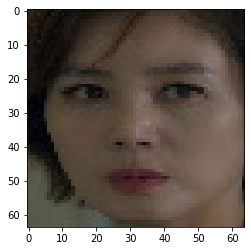

time: 143 ms (started: 2022-11-20 17:59:35 +00:00)


In [30]:
# Display the tested image.

import matplotlib.pyplot as plt

data, = ds_test.take(1)
plt.imshow(data[0][0])

In [31]:
# Check the test data's true label.
data[1]

<tf.Tensor: shape=(1, 22), dtype=int64, numpy=array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])>

time: 6.32 ms (started: 2022-11-20 17:59:35 +00:00)


In [32]:
data

(<tf.Tensor: shape=(1, 64, 64, 3), dtype=float32, numpy=
 array([[[[0.19607843, 0.15686275, 0.10588235],
          [0.18431373, 0.14509805, 0.09411765],
          [0.13725491, 0.10588235, 0.05098039],
          ...,
          [0.07058824, 0.0627451 , 0.05098039],
          [0.10588235, 0.09019608, 0.09019608],
          [0.08235294, 0.06666667, 0.06666667]],
 
         [[0.1764706 , 0.13725491, 0.08627451],
          [0.17254902, 0.13333334, 0.08235294],
          [0.12941177, 0.09803922, 0.04313726],
          ...,
          [0.0627451 , 0.05490196, 0.04313726],
          [0.09411765, 0.07843138, 0.07843138],
          [0.09411765, 0.07843138, 0.07843138]],
 
         [[0.18039216, 0.14901961, 0.09411765],
          [0.15686275, 0.1254902 , 0.07058824],
          [0.1254902 , 0.09019608, 0.04705882],
          ...,
          [0.08627451, 0.07843138, 0.06666667],
          [0.09411765, 0.08627451, 0.08235294],
          [0.07450981, 0.06666667, 0.0627451 ]],
 
         ...,
 
         

time: 6.53 ms (started: 2022-11-20 17:59:35 +00:00)


In [33]:
pred_test = clf.predict(ds_test.take(TEST_DATA_SIZE))

1980/1980 [==============================] - 5s 3ms/step
time: 5.56 s (started: 2022-11-20 17:59:35 +00:00)


In [34]:
true_test = np.concatenate([y for x, y in ds_test.take(TEST_DATA_SIZE)], axis=0)

time: 1.14 s (started: 2022-11-20 17:59:41 +00:00)


In [35]:
true_test.shape

(1980, 22)

time: 5.82 ms (started: 2022-11-20 17:59:42 +00:00)


In [36]:
from sklearn.metrics import confusion_matrix

pred_test_ls = []
true_test_ls = []
for (pred, true) in zip(pred_test, true_test):
    pred_test_ls.append(np.argmax(pred))
    true_test_ls.append(np.argmax(true))

cf_matrix_test = confusion_matrix(true_test_ls, pred_test_ls)
cf_matrix_test

array([[  0,   0,   5,  23,   0,   0,   0,   0,   0,   0,   0,   3,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   1,  20,   4,   0,   0,   0,   0,   0,   0,   0,   3,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 181,  75,   1,   0,   0,   0,   0,   0,   9,   5,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  26, 707,   2,   0,   0,   0,   0,   0,  16,   8,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   3,  62,  21,   0,   0,   0,   0,   0,   4,   5,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   2,  16,   0,   6,   0,   1,   0,   0,   3,   2,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   3,  12,   0,   0,   0,   0,   0,   0,   1,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  22,  50,   0,   0,   0,  12,   0,   0,   6,   2,   0,
          0,   0,   0,   0,   0,   0, 

time: 54.8 ms (started: 2022-11-20 17:59:42 +00:00)


Text(123.0, 0.5, 'True')

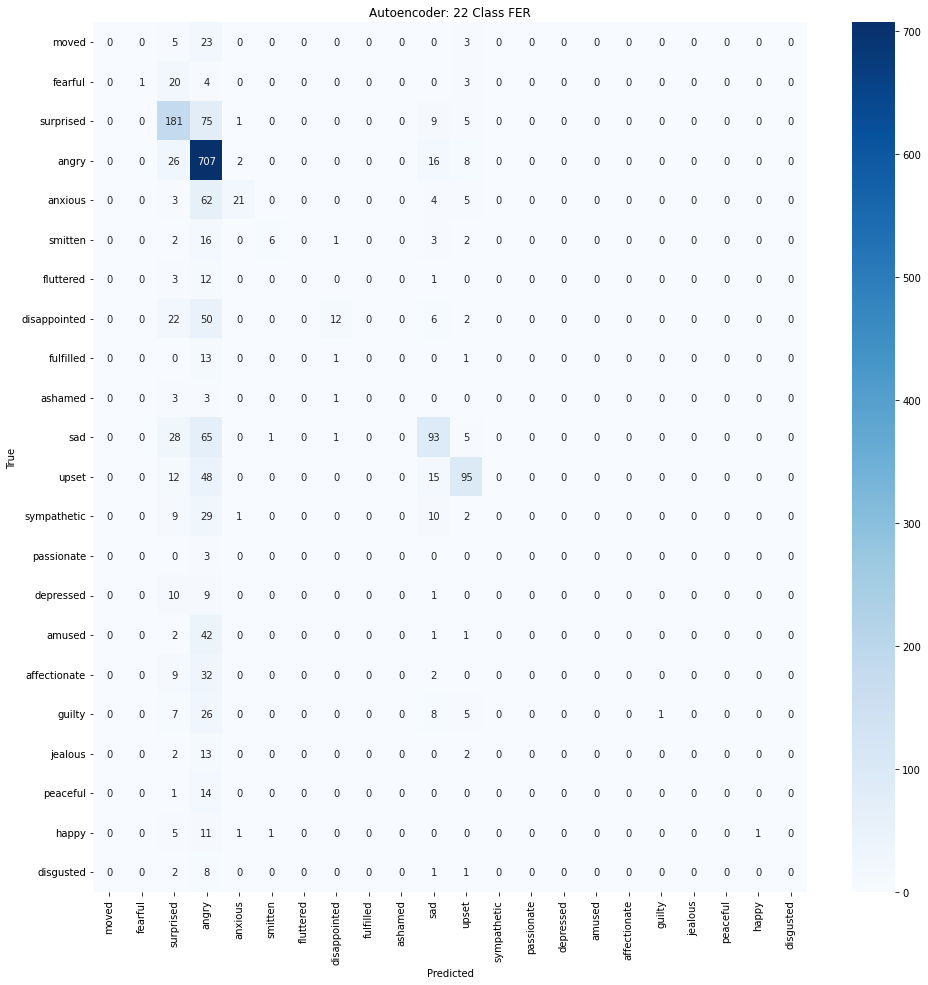

time: 1.73 s (started: 2022-11-20 17:59:42 +00:00)


In [37]:
import seaborn as sns

plt.figure(figsize = (16,16))
sns.heatmap(cf_matrix_test, annot=True, cmap='Blues', xticklabels=LABELS, yticklabels=LABELS, fmt='g')
plt.title('Autoencoder: 22 Class FER')
plt.xlabel('Predicted')
plt.ylabel('True')

### Check train data accuracy.

In [38]:
# https://docs.nvidia.com/deeplearning/dali/user-guide/docs/plugins/tensorflow_plugin_api.html

if __name__ == "__main__":
    batch_size = 1
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 22))
    pipe_train = TFRecordPipelineTrain(batch_size=batch_size, 
                            num_threads=4, 
                            device='gpu', 
                            device_id=0)

    with tf.device('/gpu:0'):
        ds_train = dali_tf.DALIDataset(
            pipeline=pipe_train,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)
        loss, acc = clf.evaluate(ds_train, steps=TRAIN_DATA_SIZE)
        print("Train accuracy:", acc)
        #predictions = clf.predict(ds_train.take(1))
        #print("A test output from the last layer:", predictions[0])
        #print("Index of the maximum value:", np.argmax(predictions[0]))
        #print("Label:", LABELS[np.argmax(predictions[0])])

15840/15840 [==============================] - 61s 4ms/step - loss: 1.4520 - accuracy: 0.5890
Train accuracy: 0.5890151262283325
time: 1min (started: 2022-11-20 17:59:43 +00:00)


In [39]:
pred_train = clf.predict(ds_train.take(TRAIN_DATA_SIZE))

15840/15840 [==============================] - 41s 3ms/step
time: 43.9 s (started: 2022-11-20 18:00:44 +00:00)


In [40]:
true_train = np.concatenate([y for x, y in ds_train.take(TRAIN_DATA_SIZE)], axis=0)

time: 8.28 s (started: 2022-11-20 18:01:28 +00:00)


In [41]:
true_train.shape

(15840, 22)

time: 6.89 ms (started: 2022-11-20 18:01:36 +00:00)


In [42]:
pred_train_ls = []
true_train_ls = []
for (pred, true) in zip(pred_train, true_train):
    pred_train_ls.append(np.argmax(pred))
    true_train_ls.append(np.argmax(true))

cf_matrix_train = confusion_matrix(true_train_ls, pred_train_ls)
cf_matrix_train

array([[   0,    0,   22,  203,    2,    0,    0,    2,    0,    0,    8,
          13,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,   17,  114,   62,    0,    0,    0,    0,    0,    0,    9,
          22,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 1481,  565,    4,    0,    0,    0,    0,    0,   49,
          73,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,  149, 5801,    6,    0,    0,    3,    0,    0,   47,
          62,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,   45,  455,  154,    0,    0,    0,    0,    0,   40,
          67,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,   17,   95,    1,   87,    0,    2,    0,    0,   27,
          11,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,   14,  103,    3,    0,    0,    0,    0,    0,    7,
           1,    0,    0,    0, 

time: 60.7 ms (started: 2022-11-20 18:01:36 +00:00)


Text(123.0, 0.5, 'True')

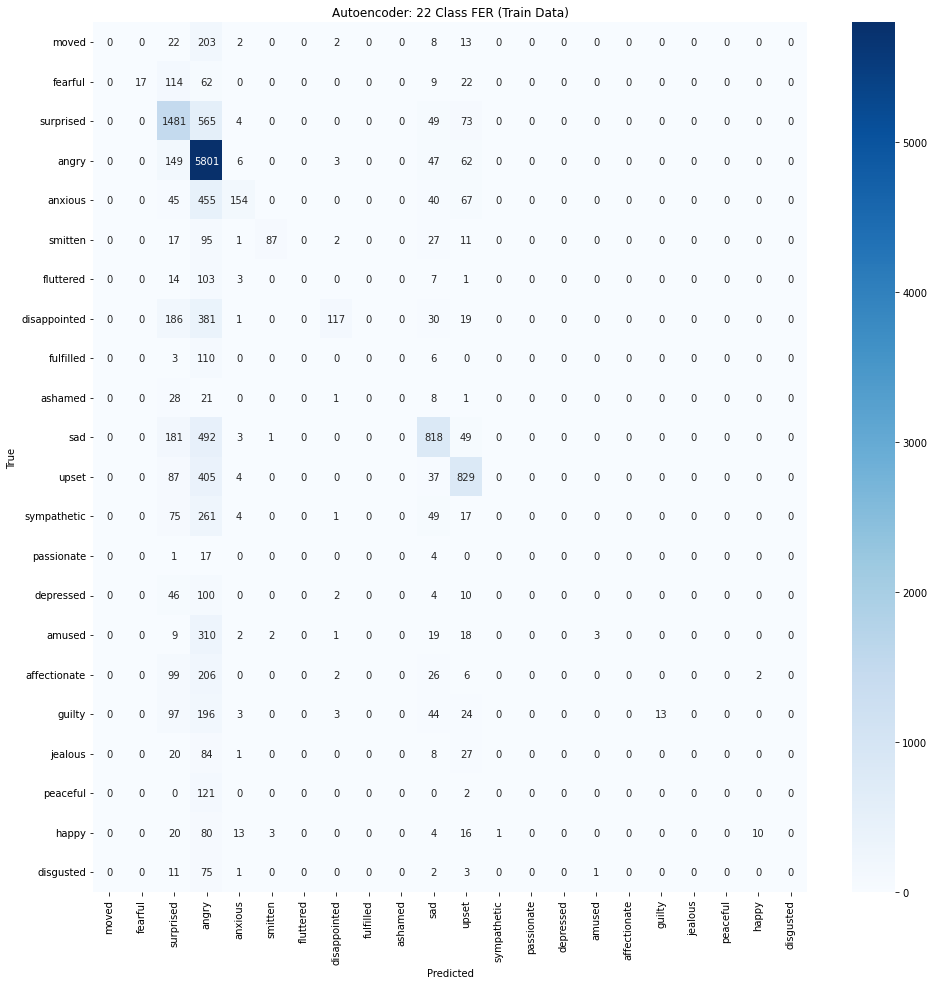

time: 1.62 s (started: 2022-11-20 18:01:36 +00:00)


In [43]:
plt.figure(figsize = (16,16))
sns.heatmap(cf_matrix_train, annot=True, cmap='Blues', xticklabels=LABELS, yticklabels=LABELS, fmt='g')
plt.title('Autoencoder: 22 Class FER (Train Data)')
plt.xlabel('Predicted')
plt.ylabel('True')